# Final Project
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__  
Throughout this course you’ve engaged with key principles required to develop scalable machine learning analyses for structured and unstructured data. Working in Hadoop Streaming and Spark you’ve learned to translate common machine learning algorithms into Map-Reduce style implementations. You’ve developed the ability to evaluate Machine Learning approaches both in terms of their predictive performance as well as their scalability. For the final project you will demonstrate these skills by solving a machine learning challenge on a new dataset. Your job is to perform Click Through Rate prediction on a large dataset of Criteo advertising data made public as part of a Kaggle competition a few years back. As you perform your analysis, keep in mind that we are not grading you on the final performance of your model or how ‘advanced’ the techniques you use but rather on your ability to explain and develop a scalable machine learning approach to answering a real question.

More about the dataset:
https://www.kaggle.com/c/criteo-display-ad-challenge

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [1]:
import re
import ast
import math
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext, Row
from pyspark.sql.functions import isnan, isnull, when, count, col

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
app_name = "fproj_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [ ]:
# create a data directory (RUN THIS CELL AS IS)
!mkdir data

In [11]:
# grab the tar.gz file from kaggle
!curl https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz -o data/dac.tar.gz

tar: Old option `g' requires an argument.
Try `tar --help' or `tar --usage' for more information.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4364M  100 4364M    0     0  9505k      0  0:07:50  0:07:50 --:--:-- 10.7M


In [5]:
# I couldn't get this to unpack the tarball, so I just did it in Windows
#!tar -xvz data/dac.tar.gz

^C


In [6]:
# take a look at the to the training data set
!head data/train.txt

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16
0	2	0	44	1	102	8	2	2	4	1	1		4	68fd1e64	f0cf0024	6f67f7e5	41274cd7	25c83c98	fe6b92e5	922afcc0	0b153874	a73ee510	2b53e5fb	4f1b46f3	623049e6	d7020589	b28479f6	e6c5b5cd	c92f3b61	07c540c4	b04e4670	21ddcdc9	5840adea	60f6221e		3a171ecb	43f13e8b	e8b83407	731c3655
0	2	0	1	14	767	89	4	2	245	1	3	3	45	287e684f	0a519c5c	02cf9876	c18be181	25c83c98	7e0ccccf	c78204a1	0b153874	a73ee510	3b08e48b	5f5e6091	8fe001f4	aa655a2f	07d13a8f	6dc710ed	36103458	8efede7f	3412118d			e587c466	ad3062eb	3a171ecb	3b183c5c		
0		893			4392		0	0	0		0			68fd1e64	2c16a946	a9a87e68	2e17d6f6	25c83c98	fe6b92e5	2e8a689b	0b153874	a73ee510	efea433b	e51ddf94	a30567ca	3516f6e6	07d13a8f	18231224	52b8680f	1e88c74f	74ef3502			6b3a5ca6		3a171ecb	9117a34a		
0	3	-1		0	2	0	3	0	0	1	1		0	8

In [5]:
# load the data into Spark RDD for convenience of use later (RUN THIS CELL AS IS)
projectRDD = sc.textFile('data/train.txt')

__`REMINDER:`__ If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

# Question 1: Question Formulation 
Introduce the goal of your analysis. What questions will you seek to answer, why do people perform this kind of analysis on this kind of data? Preview what level of performance your model would need to achieve to be practically useful.

# Question 2: Algorithm Explanation
Create your own toy example that matches the dataset provided and use this toy example to explain the math behind the algorithym that you will perform.

# Question 3: EDA & Discussion of Challenges
Determine 2-3 relevant EDA tasks that will help you make decisions about how you implement the algorithm to be scalable. Discuss any challenges that you anticipate based on the EDA you perform

#### Data Cleanup and Prep

In [6]:
sqlContext = SQLContext(sc)

# Load a text file and convert each line to a Row.
lines = sc.textFile("data/train.txt")
parts = lines.map(lambda l: l.split("\t"))
project = parts.map(lambda p: Row(label=int(p[0]), I01=p[1], I02=p[2],\
                    I03=p[3], I04=p[4], I05=p[5], I06=p[6],\
                    I07=p[7], I08=p[8], I09=p[9], I10=p[10],\
                    I11=p[11], I12=p[12], I13=p[13], C01=p[14], C02=p[15], C03=p[16],\
                    C04=p[17], C05=p[18], C06=p[19], C07=p[20], C08=p[21], C09=p[22],\
                    C10=p[23], C11=p[24], C12=p[25], C13=p[26], C14=p[27], C15=p[28],\
                    C16=p[29], C17=p[30], C18=p[31], C19=p[32], C20=p[33], C21=p[34],\
                    C22=p[35], C23=p[36], C24=p[37], C25=p[38], C26=p[39]))

# Infer the schema, and register the DataFrame as a table.
projectDF = sqlContext.createDataFrame(project)
projectDF.registerTempTable("projectTable")

In [159]:
projectDF.head()

Row(C01='68fd1e64', C02='80e26c9b', C03='fb936136', C04='7b4723c4', C05='25c83c98', C06='7e0ccccf', C07='de7995b8', C08='1f89b562', C09='a73ee510', C10='a8cd5504', C11='b2cb9c98', C12='37c9c164', C13='2824a5f6', C14='1adce6ef', C15='8ba8b39a', C16='891b62e7', C17='e5ba7672', C18='f54016b9', C19='21ddcdc9', C20='b1252a9d', C21='07b5194c', C22='', C23='3a171ecb', C24='c5c50484', C25='e8b83407', C26='9727dd16', I01='1', I02='1', I03='5', I04='0', I05='1382', I06='4', I07='15', I08='2', I09='181', I10='1', I11='2', I12='', I13='2', label=0)

In [8]:
# Look at the schema
projectDF.printSchema()

root
 |-- C1: string (nullable = true)
 |-- C10: string (nullable = true)
 |-- C11: string (nullable = true)
 |-- C12: string (nullable = true)
 |-- C13: string (nullable = true)
 |-- C14: string (nullable = true)
 |-- C15: string (nullable = true)
 |-- C16: string (nullable = true)
 |-- C17: string (nullable = true)
 |-- C18: string (nullable = true)
 |-- C19: string (nullable = true)
 |-- C2: string (nullable = true)
 |-- C20: string (nullable = true)
 |-- C21: string (nullable = true)
 |-- C22: string (nullable = true)
 |-- C23: string (nullable = true)
 |-- C24: string (nullable = true)
 |-- C25: string (nullable = true)
 |-- C26: string (nullable = true)
 |-- C3: string (nullable = true)
 |-- C4: string (nullable = true)
 |-- C5: string (nullable = true)
 |-- C6: string (nullable = true)
 |-- C7: string (nullable = true)
 |-- C8: string (nullable = true)
 |-- C9: string (nullable = true)
 |-- I1: string (nullable = true)
 |-- I10: string (nullable = true)
 |-- I11: string (nullabl

In [7]:
# Cast integer features correctly
for num in range(1,14):
    if num < 10:
        feature_name = "I0"+str(num)
    else:
        feature_name = "I"+str(num)
    projectDF = projectDF.withColumn(feature_name, projectDF[feature_name].cast("int"))


In [8]:
# Make sure the schema looks correct
projectDF.printSchema()

root
 |-- C01: string (nullable = true)
 |-- C02: string (nullable = true)
 |-- C03: string (nullable = true)
 |-- C04: string (nullable = true)
 |-- C05: string (nullable = true)
 |-- C06: string (nullable = true)
 |-- C07: string (nullable = true)
 |-- C08: string (nullable = true)
 |-- C09: string (nullable = true)
 |-- C10: string (nullable = true)
 |-- C11: string (nullable = true)
 |-- C12: string (nullable = true)
 |-- C13: string (nullable = true)
 |-- C14: string (nullable = true)
 |-- C15: string (nullable = true)
 |-- C16: string (nullable = true)
 |-- C17: string (nullable = true)
 |-- C18: string (nullable = true)
 |-- C19: string (nullable = true)
 |-- C20: string (nullable = true)
 |-- C21: string (nullable = true)
 |-- C22: string (nullable = true)
 |-- C23: string (nullable = true)
 |-- C24: string (nullable = true)
 |-- C25: string (nullable = true)
 |-- C26: string (nullable = true)
 |-- I01: integer (nullable = true)
 |-- I02: integer (nullable = true)
 |-- I03: int

In [10]:
projectDF.show()

+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---+---+---+---+---+---+---+---+-----+---+---+---+----+-----+
|      C1|     C10|     C11|     C12|     C13|     C14|     C15|     C16|     C17|     C18|     C19|      C2|     C20|     C21|     C22|     C23|     C24|     C25|     C26|      C3|      C4|      C5|      C6|      C7|      C8|      C9| I1|I10|I11|I12|I13| I2| I3| I4|   I5| I6| I7| I8|  I9|label|
+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---+---+---+---+---+---+---+---+-----+---+---+---+----+-----+
|68fd1e64|a8cd5504|b2cb9c98|37c9c164|2824a5f6|1adce6ef|8ba8b39a|891b62e7|e5ba7672|f54016b9|21ddcdc9|80e26c9b|

In [8]:
# Now that we have the schema corrected, create some feature grouping lists for easy data manipulation
numeric_features = ["I01", "I02", "I03", "I04", "I05", "I06", "I07", "I08", "I09", "I10", "I11", "I12", "I13"]
categorical_features = ["C01", "C02", "C03", "C04", "C05", "C06", "C07", "C08", "C09", "C10", "C11", "C12",\
                        "C13", "C14", "C15", "C16", "C17", "C18", "C19", "C20", "C21", "C22", "C23",\
                       "C24", "C25", "C26"]
label_and_numeric = ["label"] + numeric_features

#### Take a sample for EDA

In [81]:
# how many overall rows do we have in the training data?
# this takes a long while to calculate so skip to hard code below
numRows = projectDF.count()
numRows

45840617

In [11]:
# rather than recalculate, just put in result
numRows = 45840617

In [12]:
# get a sample to do things at a small scale with
sampleSize = 1000 # change this as we get sense of compute times
sampleDF = projectDF.sample(withReplacement = False, fraction = sampleSize/numRows, seed = 1000) 
sampleDF.createOrReplaceTempView("sampleDFTable") # I don't really know what this does
sampleDF.collect()
sampleDF.cache()

DataFrame[C01: string, C02: string, C03: string, C04: string, C05: string, C06: string, C07: string, C08: string, C09: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string, I01: int, I02: int, I03: int, I04: int, I05: int, I06: int, I07: int, I08: int, I09: int, I10: int, I11: int, I12: int, I13: int, label: bigint]

In [13]:
sampleDF.show()

+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+----+---+----+----+----+----+---+---+----+----+---+----+----+-----+
|     C01|     C02|     C03|     C04|     C05|     C06|     C07|     C08|     C09|     C10|     C11|     C12|     C13|     C14|     C15|     C16|     C17|     C18|     C19|     C20|     C21|     C22|     C23|     C24|     C25|     C26| I01|I02| I03| I04| I05| I06|I07|I08| I09| I10|I11| I12| I13|label|
+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+----+---+----+----+----+----+---+---+----+----+---+----+----+-----+
|05db9164|58e67aaf|f37b6ce2|26a569e5|26eb6185|        |d5b22f0b|1f89b562|a73ee510|5ba575e7|

In [ ]:
# How many missing values do we have and where?
sampleDF.select([count(when(isnull(c), c)).alias(c) for c in sampleDF.columns]).show()

#### Put sample pyspark dataframe into a pandas dataframe for EDA

In [50]:
samplePDF = sampleDF.toPandas() # takes a looooooooooong time

In [51]:
samplePDF.describe()

,I1,I10,I11,I12,I13,I2,I3,I4,I5,I6,I7,I8,I9,label
count,565.000000,565.000000,955.000000,228.000000,783.000000,1000.000000,776.000000,783.000000,982.000000,782.000000,955.000000,1000.000000,955.000000,1000.00000
mean,3.394690,0.598230,2.721466,1.008772,8.295019,84.898000,22.490979,7.593870,17751.262729,113.432225,15.751832,13.328000,107.967539,0.25600
std,9.226368,0.652054,4.578675,5.757195,10.939198,345.253619,150.532920,8.676397,58447.336979,343.972723,43.369605,13.564897,198.346044,0.43664
min,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,3.000000,2.000000,357.250000,8.000000,1.000000,3.000000,10.500000,0.00000
50%,1.000000,1.000000,1.000000,0.000000,5.000000,2.000000,6.500000,5.000000,2651.000000,31.500000,4.000000,8.000000,41.000000,0.00000
75%,3.000000,1.000000,3.000000,0.000000,10.000000,31.000000,17.000000,10.000000,9807.500000,104.500000,12.000000,20.000000,109.500000,1.00000
max,151.000000,4.000000,47.000000,69.000000,104.000000,5339.000000,4112.000000,70.000000,790211.000000,7532.000000,507.000000,95.000000,1968.000000,1.00000


In [ ]:
# What's the average of our outcome variable?
sampleDF.agg({"label": "avg"}).show()

In [101]:
# Create pandas df with just label and numeric columns
numericPDF = samplePDF[label_and_numeric]
numericPDF.head()

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13
0,1,NaN,18,NaN,NaN,4512.0,49.0,3.0,1,47.0,NaN,1.0,NaN,NaN
1,0,3.0,0,18.0,11.0,230.0,113.0,3.0,11,16.0,1.0,1.0,NaN,15.0
2,0,1.0,6,97.0,43.0,4.0,43.0,4.0,44,48.0,1.0,2.0,NaN,43.0
3,0,NaN,291,3.0,NaN,941.0,NaN,0.0,0,1.0,NaN,0.0,NaN,NaN
4,0,0.0,37,151.0,3.0,3913.0,157.0,11.0,22,61.0,0.0,1.0,NaN,3.0


#### EDA: See correlations

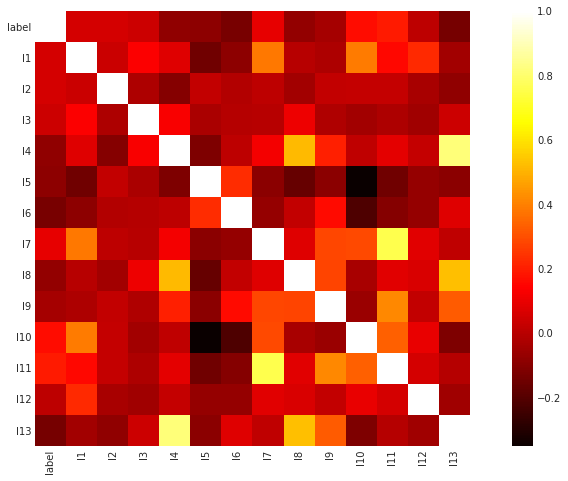

In [103]:
# Correlation heat map on integer features and label
# Turn your settings on Jupyter to white background
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
plt.imshow(numericPDF.corr(), cmap='hot', interpolation='nearest')
plt.colorbar()
labels = numericPDF.columns.tolist()
ax1.set_xticks(np.arange(len(labels)))
ax1.set_yticks(np.arange(len(labels)))
ax1.set_xticklabels(labels,rotation=90, fontsize=10)
ax1.set_yticklabels(labels,fontsize=10)
plt.show()

#### Observations from the correlation heatmap
1. Nothing seems all that correlated with the label. Best are I7, I10, I11
2. There are some features strongly correlated with outher features: (I7,I11), (I4, I13), (I4, I8), (I8, I13)

In [238]:
# Try doing chi-squared test for categorical features and the label
# relied on code from here: https://codereview.stackexchange.com/questions/96761/chi-square-independence-test-for-two-pandas-df-columns

factorizedPDF = samplePDF[label_and_numeric]
for colname in categorical_features:
    factorizedPDF[colname] = pd.factorize(samplePDF[colname])[0]
    
import scipy.stats as scs

def categories(series):
    return range(int(series.min()), int(series.max()) + 1)

def chi_square_of_df_cols(df, col1, col2):
    df_col1, df_col2 = df[col1], df[col2]

    result = [[sum((df_col1 == cat1) & (df_col2 == cat2))
               for cat2 in categories(df_col2)]
              for cat1 in categories(df_col1)]
    
    # can't have cells in contigency table <5, so tossing out small categories
    # valid if just trying to get a rough idea of associations? hopefully...
    new_cont_table = []
    for pair in result:
        if (pair[0] >= 5 and pair[1] >= 5):
            new_cont_table.append(pair)
    
    if (new_cont_table == []): 
        return None
    else:
        return scs.chi2_contingency(new_cont_table)

print("Chi_square test on each categorical column with label\n")
for colname in categorical_features:
    if chi_square_of_df_cols(factorizedPDF, colname, 'label') != None:
        p_val = chi_square_of_df_cols(factorizedPDF, colname, 'label')[1]
        print(colname, "p-value: ", p_val)
    else:
        print(colname, "p-value: None")


/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Chi_square test on each categorical column with label

C1 p-value:  0.21082798547288253
C2 p-value:  0.6435562286680369
C3 p-value:  1.0
C4 p-value:  0.012948939934941228
C5 p-value:  0.8535936414496317
C6 p-value:  0.049581973659291234
C7 p-value:  0.797861519994188
C8 p-value:  0.6135336372023791
C9 p-value:  7.50591017192037e-05
C10 p-value:  1.0
C11 p-value:  0.7938565664416881
C12 p-value:  1.0
C13 p-value:  0.6702820959999762
C14 p-value:  0.0004643180576810328
C15 p-value: None
C16 p-value:  0.010838360359114419
C17 p-value:  6.215519829380432e-06
C18 p-value:  0.36916060790189564
C19 p-value:  0.4073140424351105
C20 p-value:  0.3279960391349751
C21 p-value:  0.010838360359114419
C22 p-value:  0.3632684079519511
C23 p-value:  0.2132366139150885
C24 p-value:  0.7881904129396066
C25 p-value:  0.3848364145236987
C26 p-value:  0.4419905004244705


#### Results of the chi-squared correlation tests on categories
C4, C6, C9, C14, C16, C17, C21 appear to show significant correlation

#### EDA: Histograms

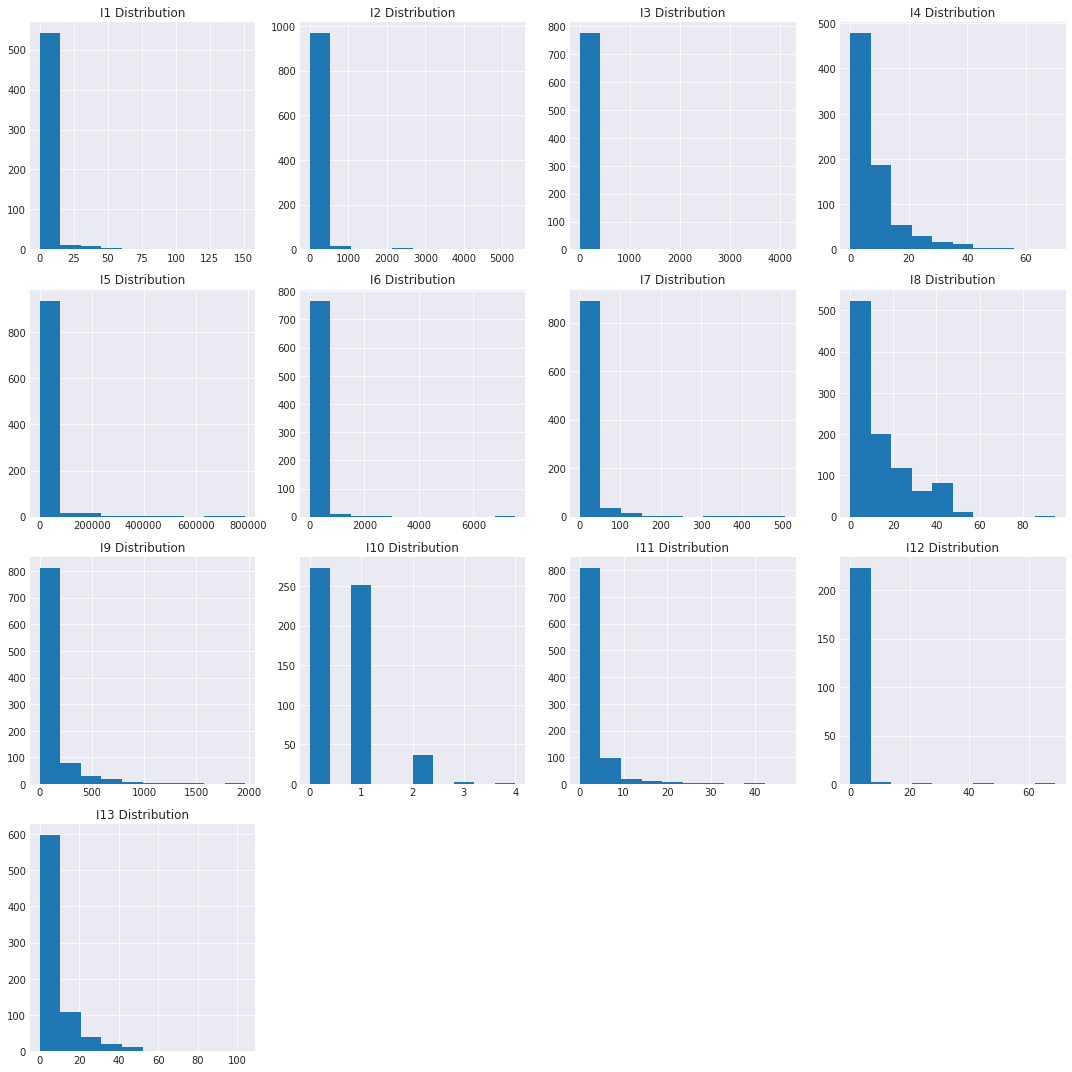

In [116]:
# EDA histograms
subplot_index = 0 # starting subplot number for chart 4x4 grid
fig=plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for feature in numeric_features:
    subplot_index += 1
    ax=fig.add_subplot(4,4,subplot_index)
    samplePDF[feature].hist(bins=10,ax=ax)
    ax.set_title(feature+" Distribution")
    fig.tight_layout() 
plt.show()


#### EDA: Suspect data?

In [55]:
# Investigate I2 column since it seems to be only with negatives.
negvalues = samplePDF[samplePDF.I2 < 0]
negvalues.I2.count()

# 116 out of 1000 are negative, so that doesn't feel like a couple errors. Also, there is -1 and -2 values.

116

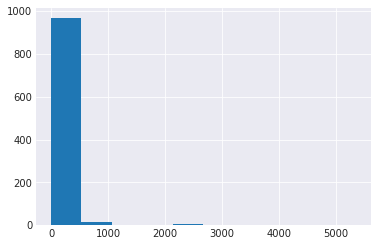

In [56]:
samplePDF.I2.hist()

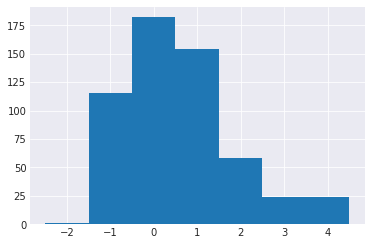

In [74]:
samplePDF.I2.hist(bins=[-2.5,-1.5,-0.5,0.5,1.5,2.5,3.5,4.5])
# this seems like the -1 and -2 are real values given the number of 1s and 2s on the positive side.

#### Data cleanup continued: Deal with missing data

In [15]:
# Create missing data features
# Taking a cue from this response: https://stats.stackexchange.com/questions/228622/handling-null-value-in-logistic-regression

for feature in numeric_features:
    feature_name = feature + "_missing"
    sampleDF = sampleDF.withColumn(feature_name, sampleDF[feature].isNull().cast("int"))
sampleDF.collect()
sampleDF.cache()

# create a list for referencing the missing data features
missing = ["I01_missing", "I02_missing", "I03_missing", "I04_missing", "I05_missing", "I06_missing", \
           "I07_missing", "I08_missing", "I09_missing", "I10_missing", "I11_missing", "I12_missing", \
           "I13_missing"]

In [16]:
# ALTERNATE ROUTE: JUST DELETE ROWS WITH NAS
noNADF = sampleDF.na.drop().cache() # this just drops any row that has an NA

In [17]:
# now that we've created missing value features, fill in NAs with 0s
cleanDF = sampleDF.na.fill(0) # puts zeros across whole matrix, including categorical. problem?
cleanDF.collect()
cleanDF.cache()

DataFrame[C01: string, C02: string, C03: string, C04: string, C05: string, C06: string, C07: string, C08: string, C09: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string, I01: int, I02: int, I03: int, I04: int, I05: int, I06: int, I07: int, I08: int, I09: int, I10: int, I11: int, I12: int, I13: int, label: bigint, I01_missing: int, I02_missing: int, I03_missing: int, I04_missing: int, I05_missing: int, I06_missing: int, I07_missing: int, I08_missing: int, I09_missing: int, I10_missing: int, I11_missing: int, I12_missing: int, I13_missing: int]

In [18]:
cleanDF.take(1) # make sure all looking good

[Row(C01='05db9164', C02='58e67aaf', C03='f37b6ce2', C04='26a569e5', C05='26eb6185', C06='', C07='d5b22f0b', C08='1f89b562', C09='a73ee510', C10='5ba575e7', C11='ac48f34e', C12='ebf6ab0e', C13='a8840224', C14='051219e6', C15='d83fb924', C16='81c9500c', C17='e5ba7672', C18='c21c3e4c', C19='2e7e0472', C20='a458ea53', C21='c5d4a622', C22='', C23='32c7478e', C24='bc8b14b9', C25='9b3e8820', C26='cdd2b5b7', I01=0, I02=18, I03=0, I04=0, I05=4512, I06=49, I07=3, I08=1, I09=47, I10=0, I11=1, I12=0, I13=0, label=1, I01_missing=1, I02_missing=0, I03_missing=1, I04_missing=1, I05_missing=0, I06_missing=0, I07_missing=0, I08_missing=0, I09_missing=0, I10_missing=1, I11_missing=0, I12_missing=1, I13_missing=1)]

#### Create toy RDD dataset to test algorithms

In [19]:
# We want an RDD in this shape: tuple of (features_array, y)
TOY_SIZE = 75 # create a toy set that's just 10 rows
toy_numeric = label_and_numeric + missing
toyIntRDD = cleanDF.limit(TOY_SIZE).select(toy_numeric).rdd.map(lambda x: (np.array(x[1:27]), x[0]))
toyIntRDD.take(10)

[(array([   0,   18,    0,    0, 4512,   49,    3,    1,   47,    0,    1,
            0,    0,    1,    0,    1,    1,    0,    0,    0,    0,    0,
            1,    0,    1,    1]), 1),
 (array([  3,   0,  18,  11, 230, 113,   3,  11,  16,   1,   1,   0,  15,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0]), 0),
 (array([ 1,  6, 97, 43,  4, 43,  4, 44, 48,  1,  2,  0, 43,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  1,  0]), 0),
 (array([  0, 291,   3,   0, 941,   0,   0,   0,   1,   0,   0,   0,   0,
           1,   0,   0,   1,   0,   1,   0,   0,   0,   1,   0,   1,   1]), 0),
 (array([   0,   37,  151,    3, 3913,  157,   11,   22,   61,    0,    1,
            0,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    1,    0]), 0),
 (array([   0,   24,   19,    1, 8550,   15,    6,    1,   17,    0,    1,
            0,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    1,    0]), 0

In [20]:
# Turn sample dataframe into RDD for tests on larger data
sampleIntRDD = cleanDF.select(toy_numeric).rdd.map(lambda x: (np.array(x[1:27]), x[0]))
sampleIntRDD.take(1)

[(array([   0,   18,    0,    0, 4512,   49,    3,    1,   47,    0,    1,
            0,    0,    1,    0,    1,    1,    0,    0,    0,    0,    0,
            1,    0,    1,    1]), 1)]

In [23]:
# helper function to normalize the data [-1, 1] with RDDs
# include the missing value binary variables? yes: https://stats.stackexchange.com/questions/69568/whether-to-rescale-indicator-binary-dummy-predictors-for-lasso

def normalize(dataRDD):
    """
    Scale and center data round mean of each feature.
    Args:
        dataRDD - records are tuples of (features_array, y)
    Returns:
        normedRDD - records are tuples of (features_array, y)
    """
    featureMeans = dataRDD.map(lambda x: x[0]).mean()
    featureStdev = np.sqrt(dataRDD.map(lambda x: x[0]).variance())
    featureStdev[featureStdev == 0] = 1 # in cases where no variation, div by 1
    normedRDD = dataRDD.map(lambda x: ((x[0] - featureMeans)/featureStdev,x[1]))
    return normedRDD


In [24]:
normedToyIntRDD = normalize(toyIntRDD)
normedSampleIntRDD = normalize(sampleIntRDD)

In [25]:
# create and normalize an RDD for the dropped NAs dataframe
noNARDD = noNADF.select(toy_numeric).rdd.map(lambda x: (np.array(x[1:14]), x[0]))
normedNONARDD = normalize(noNARDD)

In [26]:
normedToyIntRDD.take(1)

[(array([-0.42124075, -0.22048053, -0.42874752, -0.64643798, -0.20659264,
         -0.1740056 , -0.21632725, -0.90934651, -0.20190941, -0.71741751,
         -0.34343255, -0.22196863, -0.64766706,  1.29559694,  0.        ,
          1.84709629,  1.92028644,  0.        , -0.45790547, -0.11624764,
          0.        , -0.11624764,  1.29559694, -0.11624764,  0.47907014,
          1.92028644]), 1)]

In [27]:
normedSampleIntRDD.take(1)

[(array([-0.26898734, -0.19386176, -0.13137213, -0.71754741, -0.22299439,
         -0.12908935, -0.28345785, -0.90927111, -0.2877104 , -0.59039324,
         -0.35473649, -0.08286957, -0.63303379,  1.13967126,  0.        ,
          1.86125917,  1.89955124, -0.1353881 , -0.52798899, -0.21707238,
          0.        , -0.21707238,  1.13967126, -0.21707238,  0.54344897,
          1.89955124]), 1)]

In [28]:
normedNONARDD.take(1)

[(array([-0.48170037,  0.52586638,  1.89756179,  0.39644477, -0.08282193,
          1.11317704, -0.19015982,  1.81435088,  0.08119144, -0.95934324,
         -0.51332743, -0.18791419,  0.63795409]), 0)]

#### L1 Normalization

In [126]:
# Log loss function
# adapted from HW4 and https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html
# https://www.internalpointers.com/post/cost-function-logistic-regression

def LogLoss(dataRDD, W):
    """
    Compute log loss.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))

#    loss = augmentedData.map(lambda x: (-x[1]*np.log(1 / (1 + np.exp(-np.dot(W, x[0])))) -\
#                                        (1-x[1])*np.log(1- (1 / (1 + np.exp(-np.dot(W, x[0]))))), 1)) \
# NOT SURE ABOUT MINUS SIGN IN MIDDLE, AND TO SOME DEGREE AT START
    loss = augmentedData.map(lambda x: (-np.dot(x[1],np.log(1 / (1 + np.exp(-np.dot(W, x[0]))))) -\
                                        np.dot((1-x[1]),np.log(1- (1 / (1 + np.exp(-np.dot(W, x[0])))))), 1)) \
                        .reduce(lambda x,y:(x[0]+y[0], x[1]+y[1]))

    loss = float(loss[0])/loss[1]
    
    return loss

In [128]:
# Update the gradient
# Adapted from HW4 and https://nbviewer.jupyter.org/urls/dl.dropbox.com/s/r20ff7q0yni5kiu/LogisticRegression-Spark-Notebook.ipynb

def GDUpdate_wReg(dataRDD, W, N, learningRate = 0.1, regType = None, regParam = 0.1):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, bias still at index 0
    """
    # augmented data
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    
    new_model = None
    
    # calculate the gradient
    
    gradient = augmentedData.map(lambda x: (1 / (1 + np.exp(-x[1]*np.dot(W, x[0])))-1) * x[1] * np.array(x[0]))\
                    .reduce(lambda x, y: x + y)
    if regType == "ridge":
        wReg = W * 1
        wReg = np.append([0], wReg[1:]) # remove the bias term ahead of regularization        
    elif regType == "lasso":
        wReg = W * 1
        wReg = np.append([0], wReg[1:]) # remove the bias term ahead of regularization
        wReg = (wReg>0).astype(int) * 2-1
    else:
        wReg = np.zeros(W.shape[0])
    gradient = gradient + regParam * wReg  #gradient:  GD of Squared Error+ GD of regularized term 
    new_model = W - learningRate * gradient / N

    return new_model

In [129]:
# part d - ridge/lasso gradient descent function
def GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 20, learningRate = 0.1,
                         regType = None, regParam = 0.1, verbose = True):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # calculate N here so you don't have to do it in the for looped function call
    N = trainRDD.count()

    # make a starter set of weights if none provided
    featureLen = len(trainRDD.take(1)[0][0])
    if wInit is None:
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:
        w = wInit
    model = w
    
    # perform nSteps updates & compute test and train loss after each
    for idx in range(nSteps):  
   
        # update the model
        model = GDUpdate_wReg(trainRDD, model, N, learningRate, regType, regParam)
        
        # keep track of test/train loss for plotting
        training_loss = LogLoss(trainRDD, model)
        test_loss = LogLoss(testRDD, model)
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [136]:
# split data into train and test and train a logistic regression model with L1 regularization
# adapted from HW4 code

# initialize the weights with rough mean for bias and zeros for coeffecients
wInit = np.array([-0.77, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

trainRDD, testRDD = normedNONARDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
lasso_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 10, regParam = 0.1)
print(f"\n... trained {len(lasso_results[2])} iterations in {time.time() - start} seconds")

----------
STEP: 1
training loss: 0.5950980276946545
test loss: 0.6148486924511977
Model: [-0.751, 0.0, 0.001, -0.004, -0.0, -0.004, -0.003, 0.003, -0.002, 0.0, 0.004, 0.008, 0.001, -0.005]
----------
STEP: 2
training loss: 0.5936047886023331
test loss: 0.6124879682618041
Model: [-0.732, 0.0, 0.002, -0.008, -0.0, -0.008, -0.007, 0.006, -0.003, 0.001, 0.008, 0.015, 0.002, -0.011]
----------
STEP: 3
training loss: 0.592304899720572
test loss: 0.6103335633676733
Model: [-0.713, 0.0, 0.002, -0.012, -0.0, -0.012, -0.01, 0.009, -0.005, 0.001, 0.013, 0.023, 0.003, -0.016]
----------
STEP: 4
training loss: 0.5911924175141046
test loss: 0.6083797929158913
Model: [-0.694, 0.0, 0.003, -0.016, -0.001, -0.015, -0.013, 0.012, -0.006, 0.002, 0.016, 0.03, 0.004, -0.021]
----------
STEP: 5
training loss: 0.5902611048141446
test loss: 0.6066207437845018
Model: [-0.676, 0.0, 0.004, -0.019, -0.001, -0.019, -0.016, 0.014, -0.008, 0.002, 0.02, 0.037, 0.005, -0.026]
----------
STEP: 6
training loss: 0.589504

In [70]:
# make error curve plots that show declining loss as walk down the gradient
# from HW4 code

def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of log loss) , testLoss (list of log loss)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Log Loss')
    if title:
        plt.title(title)
    plt.show()

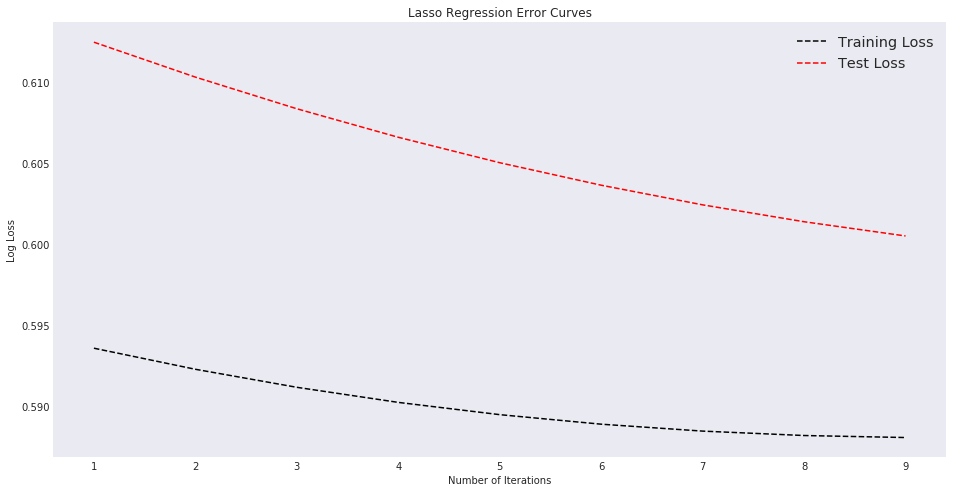

In [137]:
# save results to csv files
# from HW4 code

trainLoss, testLoss, models = lasso_results
np.savetxt(PWD + '/data/lasso_models.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/lasso_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')
plotErrorCurves(trainLoss, testLoss, title = 'Lasso Regression Error Curves' )

In [138]:
# get the best L1 model from files
# from HW4 code

lasso_models = np.loadtxt(PWD + '/data/lasso_models.csv', dtype=float, delimiter=',')
best_lasso = lasso_models[-1,:]

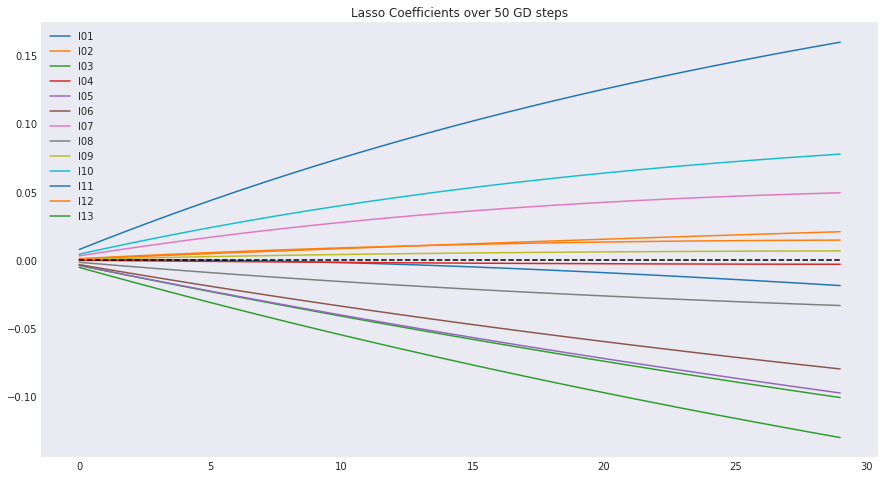

In [134]:
# show the coeffecients as L1 steps increase
# adapted from HW4 code

def plotCoeffs(models, featureNames, title):
    """
    Helper Function to show how coefficients change as we train.
    """
    fig, ax = plt.subplots(figsize = (15,8))
    X = list(range(len(models)))
    for data, name in zip(models.T, featureNames):
        if name == "Bias":
            continue
        ax.plot(X, data, label=name)
    ax.plot(X,[0]*len(X), 'k--')
    plt.title(title)
    plt.legend()
    plt.show
    
# use if starting with the models with the missing data features
#plotCoeffs(lasso_models, ['Bias'] + numeric_features + missing, "Lasso Coefficients over 50 GD steps")

# use if starting with the model where NA rows were dropped
plotCoeffs(lasso_models, ['Bias'] + numeric_features, "Lasso Coefficients over 50 GD steps")

In [139]:
# test accuracy of the model
# from learning here: https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html

def sigmoid(row):
    sig = []
    for z in row:
        sig.append(1/(1+np.exp(-z)))
    return sig

def decision_boundary(prob):
    return 1 if prob >= .5 else 0

def classify(predictions):
    '''
    input  - N element array of predictions between 0 and 1
    output - N element array of 0s (False) and 1s (True)
    '''
    classifications = []
    for prediction in predictions:
        classifications.append(decision_boundary(prediction))
    return classifications

def calc_accuracy(predicted_labels, actual_labels):
    error_count = 0
    num_predictions = len(actual_labels)
    for compare in range(num_predictions):
        if predicted_labels[compare] != actual_labels[compare]:
            error_count += 1
    return 1.0 - (float(error_count) / num_predictions)

def compare(x,y):
    return int(x != y)

coeffs = best_lasso[1:] # coefficients
b = best_lasso[0] # bias term
actual_labels = testRDD.map(lambda x: x[1]).collect()

# spark version
#error_count = testRDD.map(lambda x: (np.dot(coeffs, x[0])+b, x[1])) \
#                    .map(lambda x: (1/(1+np.exp(-x[0])), x[1])) \
#                    .map(lambda x: (decision_boundary(x[0]), x[1])) \
#                    .map(lambda x: (compare(x[0],x[1]),1)) \
#                    .reduce(lambda x,y: (x[0]+y[0],x[1]+y[1]))
#
#print("accuracy is", 1.0 - (float(error_count[0]) / error_count[1]))
# regular version
mxb = testRDD.map(lambda x: np.dot(coeffs, x[0])+b).collect() # mx+b
probabilities = sigmoid(mxb) # put through sigmoid
predictions = classify(probabilities) # put through a decision boundary
print ("accuracy is", calc_accuracy(predictions, actual_labels))

accuracy is 0.6923076923076923


In [43]:
error_count

(152, 216)

# Question 4: Algorithm Implementation 
Develop a 'homegrown' implementation of the algorithn, apply it to the training dataset and evaluate your results on the test set. 

# Question 5: Application of Course Concepts
Pick 3-5 key course concepts and discuss how your work on this assignment illustrates an understanding of these concepts. 